# Thought Anchors Figure Replication: Per-Chunk Counterfactual Metrics

This notebook generates per-example figures similar to those in the Thought Anchors paper,
plotting the counterfactual accuracies and importance (KL) per chunk.
It consumes the annotated dataset produced by `experiments/annotate_data.py`.


In [1]:
import os, json, pathlib
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Parameters
model_name = 'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B'
max_examples = 24   # number of examples to render
save_figs = False
show_figs = True   # set True to display inline if running interactively
figsize = (8, 4)

# Paths (respect repo layout)
repo_root = pathlib.Path.cwd().resolve().parents[0] if (pathlib.Path.cwd()).exists() else pathlib.Path.cwd().resolve()
model_tag = model_name.replace('/', '-')
annotated_path = repo_root / 'generated_data' / f'generated_data_annotated_{model_tag}.json'
out_dir = repo_root / 'generated_data' / 'figures' / 'ta_per_chunk'
out_dir.mkdir(parents=True, exist_ok=True)
annotated_path

PosixPath('/home/cutterdawes/SteeringThoughtAnchors/generated_data/generated_data_annotated_deepseek-ai-DeepSeek-R1-Distill-Qwen-1.5B.json')

In [2]:
# Load annotated data
assert annotated_path.exists(), f'Missing annotated dataset: {annotated_path}'
with open(annotated_path, 'r') as f:
    data = json.load(f)
# Keep only entries that contain the required fields
examples = [d for d in data if isinstance(d.get('counterfactual_accuracies'), list) and isinstance(d.get('counterfactual_importance_kl'), list)]
if max_examples is not None:
    examples = examples[:max_examples]
len(examples)

2

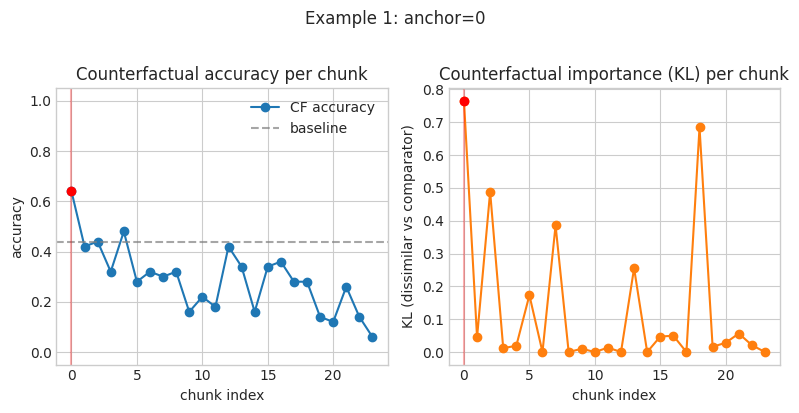

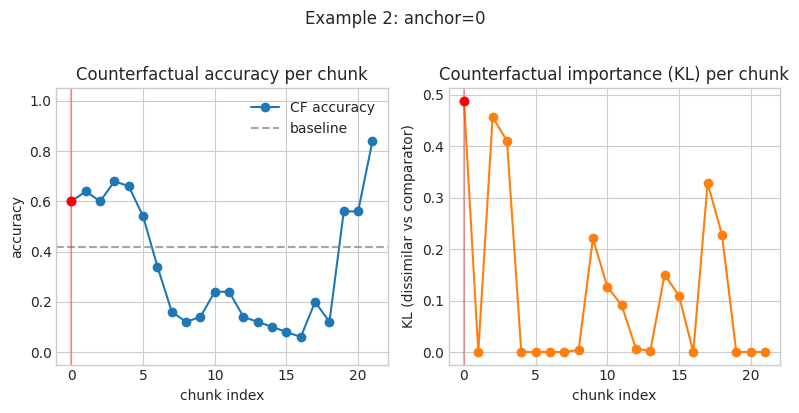

2

In [3]:
plt.style.use('seaborn-v0_8-whitegrid')
rendered = 0
for i, ex in enumerate(examples, start=1):
    acc = ex.get('counterfactual_accuracies', [])
    kls = ex.get('counterfactual_importance_kl', [])
    anchor_idx = ex.get('thought_anchor_idx', None)
    base_acc = ex.get('baseline_accuracy', None)
    prompt_preview = (ex.get('prompt','') or '').replace('',' ')
    if len(prompt_preview) > 100:
        prompt_preview = prompt_preview[:100] + '...'

    x = np.arange(max(len(acc), len(kls)))
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=True)

    # Left: accuracy per chunk
    axes[0].plot(x[:len(acc)], acc, marker='o', color='#1f77b4', label='CF accuracy')
    if base_acc is not None:
        axes[0].axhline(base_acc, linestyle='--', color='gray', alpha=0.7, label='baseline')
    if anchor_idx is not None and 0 <= anchor_idx < len(acc):
        axes[0].axvline(anchor_idx, color='red', alpha=0.3)
        axes[0].scatter([anchor_idx], [acc[anchor_idx]], color='red', zorder=3)
    axes[0].set_title('Counterfactual accuracy per chunk')
    axes[0].set_xlabel('chunk index')
    axes[0].set_ylabel('accuracy')
    axes[0].set_ylim(-0.05, 1.05)
    axes[0].legend(loc='upper right')

    # Right: importance KL per chunk
    axes[1].plot(x[:len(kls)], kls, marker='o', color='#ff7f0e', label='importance KL')
    if anchor_idx is not None and 0 <= anchor_idx < len(kls):
        axes[1].axvline(anchor_idx, color='red', alpha=0.3)
        axes[1].scatter([anchor_idx], [kls[anchor_idx]], color='red', zorder=3)
    axes[1].set_title('Counterfactual importance (KL) per chunk')
    axes[1].set_xlabel('chunk index')
    axes[1].set_ylabel('KL (dissimilar vs comparator)')

    fig.suptitle(f'Example {i}: anchor={anchor_idx}', y=1.02)
    fig.tight_layout()

    if save_figs:
        fname = out_dir / f'ta_per_chunk_ex{i:03d}.png'
        fig.savefig(fname, dpi=150, bbox_inches='tight')
    if show_figs:
        plt.show()
    else:
        plt.close(fig)
    rendered += 1

rendered

In [4]:
examples[0]

{'prompt': 'Evaluate $\\sqrt[3]{12}\\times \\sqrt[3]{20}\\times \\sqrt[3]{15}\\times \\sqrt[3]{60}$.',
 'model_input_prompt': '<｜User｜>Solve the following problem step by step. You MUST put your final answer in \\boxed{}.\n\nProblem: Evaluate $\\sqrt[3]{12}\\times \\sqrt[3]{20}\\times \\sqrt[3]{15}\\times \\sqrt[3]{60}$.\n\nThink carefully and show your reasoning. At the end, provide the final answer enclosed in \\boxed{}.<｜Assistant｜><think>\n',
 'raw_response': "<｜User｜>Solve the following problem step by step. You MUST put your final answer in \\boxed{}.\n\nProblem: Evaluate $\\sqrt[3]{12}\\times \\sqrt[3]{20}\\times \\sqrt[3]{15}\\times \\sqrt[3]{60}$.\n\nThink carefully and show your reasoning. At the end, provide the final answer enclosed in \\boxed{}.<｜Assistant｜><think>\nOkay, so I have this problem to solve: evaluate the product of four cube roots multiplied together. It's written as √[3]{12} × √[3]{20} × √[3]{15} × √[3]{60}. Hmm, cube roots can sometimes be tricky, but I reme